# Latent diffusion model

In [1]:
import os
import sys
import time
import math
import logging
import warnings
import numpy as np
from glob import glob

# supress regular warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
logging.getLogger("tensorflow").setLevel(logging.ERROR) 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# supress tensorflow warnings
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

# adjust for time step embedding layer
tf.config.run_functions_eagerly(True)

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import model_utils as mu

## Hyperparameters

In [14]:
total_timesteps = 50 # diffusion time steps
norm_groups = 8 # number of attention heads, number of layer normalization groups 

# min-max values of the diffusion target (learning target) 
clip_min = -1.0
clip_max = 1.0

widths = [64, 96, 128, 256] # number of convolution kernels per up-/downsampling level
left_attention = [False, True, True, True] # True: use multi-head attnetion on each up-/downsampling level
right_attention = [False, True, True, True]
num_res_blocks = 2  # Number of residual blocks

input_shape = (32, 32, 8) # the tensor shape of reverse diffusion input
gfs_shape = (16, 16, 256) # the tensor shape of GFS embeddings

F_x = 0.1 # the scale of GFS embeddings
F_y = 1/6.3 # the scale of VQ-VAE codes

N_atten1 = np.sum(left_attention)
N_atten2 = np.sum(right_attention)

# location of the previous weights
model_name = '/glade/work/ksha/GAN/models/LDM_atten{}-{}_res{}_tune2/'.format(
    N_atten1, N_atten2, num_res_blocks)

lr = 0 # learning rate

## Model design

In [15]:
def build_model(input_shape, gfs_shape, widths, left_attention, right_attention, num_res_blocks=2, norm_groups=8,
                interpolation="nearest", activation_fn=keras.activations.swish,):

    first_conv_channels = widths[0]
    
    image_input = layers.Input(shape=input_shape, name="image_input")
    time_input = keras.Input(shape=(), dtype=tf.int64, name="time_input")
    gfs_input = layers.Input(shape=gfs_shape, name="gfs_input")
    
    x = layers.Conv2D(first_conv_channels, kernel_size=(3, 3), padding="same",
                      kernel_initializer=mu.kernel_init(1.0),)(image_input)

    temb = mu.TimeEmbedding(dim=first_conv_channels * 4)(time_input)
    temb = mu.TimeMLP(units=first_conv_channels * 4, activation_fn=activation_fn)(temb)

    skips = [x]

    # DownBlock
    has_attention = left_attention
    for i in range(len(widths)):
        for _ in range(num_res_blocks):
            x = mu.ResidualBlock(widths[i], groups=norm_groups, activation_fn=activation_fn)([x, temb])
            
            if has_attention[i]:
                x_gfs = gfs_input
                x_gfs = layers.Conv2D(widths[i], kernel_size=(3, 3), padding="same",)(x_gfs)
                x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
                x_gfs = activation_fn(x_gfs)
                
                x = layers.MultiHeadAttention(num_heads=norm_groups, key_dim=widths[i])(x, x_gfs)
                
            skips.append(x)

        if widths[i] != widths[-1]:
            x = mu.DownSample(widths[i])(x)
            skips.append(x)

    # MiddleBlock
    x = mu.ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)([x, temb])
    
    x_gfs = gfs_input
    x_gfs = layers.Conv2D(widths[i], kernel_size=(3, 3), padding="same",)(x_gfs)
    x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
    x_gfs = activation_fn(x_gfs)
    
    x = layers.MultiHeadAttention(num_heads=norm_groups, key_dim=widths[-1])(x, x_gfs)
    
    x = mu.ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)([x, temb])

    # UpBlock
    has_attention = right_attention
    for i in reversed(range(len(widths))):
        for _ in range(num_res_blocks + 1):
            x = layers.Concatenate(axis=-1)([x, skips.pop()])
            x = mu.ResidualBlock(widths[i], groups=norm_groups, activation_fn=activation_fn)([x, temb])
            
            if has_attention[i]:
                x_gfs = gfs_input
                x_gfs = layers.Conv2D(widths[i], kernel_size=(3, 3), padding="same",)(x_gfs)
                x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
                x_gfs = activation_fn(x_gfs)
                
                x = layers.MultiHeadAttention(num_heads=norm_groups, key_dim=widths[i])(x, x_gfs)

        if i != 0:
            x = mu.UpSample(widths[i], interpolation=interpolation)(x)

    # End block
    x = layers.GroupNormalization(groups=norm_groups)(x)
    x = activation_fn(x)
    x = layers.Conv2D(input_shape[-1], (3, 3), padding="same", kernel_initializer=mu.kernel_init(0.0))(x)
    return keras.Model([image_input, time_input, gfs_input], x, name="unet")

In [16]:
# Reverse diffusino model
model = build_model(input_shape=input_shape, gfs_shape=gfs_shape, widths=widths,
                    left_attention=left_attention, right_attention=right_attention, 
                    num_res_blocks=num_res_blocks, norm_groups=norm_groups, activation_fn=keras.activations.swish)

# Compile the mdoel
model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(learning_rate=lr),)

# load previous weights
W_old = mu.dummy_loader(model_name)
model.set_weights(W_old)

# configure the forward diffusion steps
gdf_util = mu.GaussianDiffusion(timesteps=total_timesteps)

## Validation set preparation

In [6]:
L_valid = 270 # number of validation samples

# locations of training data
BATCH_dir = '/glade/campaign/cisl/aiml/ksha/BATCH_Diffusion/'

# preparing training batches
filenames = np.array(sorted(glob(BATCH_dir+'valid*.npy')))

L = len(filenames)
filename_valid = filenames[::5][:L_valid]
filename_train = list(set(filenames) - set(filename_valid))

L_train = len(filename_train)

Y_valid = np.empty((L_valid,)+input_shape)
X_valid = np.empty((L_valid,)+gfs_shape)

for i, name in enumerate(filename_valid):
    temp_data = np.load(name, allow_pickle=True)[()]
    X_valid[i, ...] = F_x*temp_data['GFS_latent']
    Y_valid[i, ...] = F_y*temp_data['Y_latent']

# validate on random timesteps
t_valid_ = np.random.uniform(low=0, high=total_timesteps, size=(L_valid,))
t_valid = t_valid_.astype(int)

# sample random noise to be added to the images in the batch
noise_valid = np.random.normal(size=((L_valid,)+input_shape))
images_valid = np.array(gdf_util.q_sample(Y_valid, t_valid, noise_valid))

# validation prediction example:
# pred_noise = model.predict([images_valid, t_valid, X_valid])

In [12]:
pred_noise = model.predict([images_valid, t_valid, X_valid])
record_temp = np.mean(np.abs(noise_valid - pred_noise))

9/9 [==============================] - 3s 302ms/step


In [60]:
record_temp

0.10747959694264711

## Plot examples

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
def reverse_diffuse(model, x_in1, x_in2, total_timesteps, gdf_util):
    L_valid = len(x_in1)
    x_out = np.empty(x_in1.shape)

    for i in range(L_valid):
        x1 = x_in1[i, ...][None, ...]
        x2 = x_in2[i, ...][None, ...]
        
        for t in reversed(range(0, total_timesteps)):
            tt = tf.cast(tf.fill(1, t), dtype=tf.int64)
            pred_noise = model.predict([x1, tt, x2], verbose=0)
            model_mean, _, model_log_variance =  gdf_util.p_mean_variance(pred_noise, x=x1, t=tt, clip_denoised=True)
            nonzero_mask = (1 - (np.array(tt)==0)).reshape((1, 1, 1, 1))
            x1 = np.array(model_mean) + nonzero_mask * np.exp(0.5 * np.array(model_log_variance)) * np.random.normal(size=x1.shape)
        x_out[i, ...] = x1

    return x_out

### Testing set preparation

* diffusion bridge can work
* mixing noise into the output of forward diffusion can increase ensemble spread
* rerun the same reverse diffusion multiple times, the result will be slightly different

In [21]:
L_valid = 270 # number of validation samples

# locations of training data
BATCH_dir = '/glade/campaign/cisl/aiml/ksha/BATCH_Diffusion/'

# preparing training batches
filenames = np.array(sorted(glob(BATCH_dir+'valid*.npy')))

L = len(filenames)
filename_valid = filenames[::5][:L_valid]

Y_valid = np.empty((L_valid,)+input_shape)
X_valid = np.empty((L_valid,)+gfs_shape)

for i, name in enumerate(filename_valid):
    temp_data = np.load(name, allow_pickle=True)[()]
    X_valid[i, ...] = F_x*temp_data['GFS_latent']
    Y_valid[i, ...] = F_y*temp_data['Y_latent']

In [53]:
# images_valid = np.random.normal(size=((L_valid,)+input_shape))

t_valid_ = (total_timesteps-1)*np.ones(L_valid)
t_valid = t_valid_.astype(int)

# sample random noise to be added to the images in the batch
noise_valid = np.random.normal(size=((L_valid,)+input_shape))
images_valid = np.array(gdf_util.q_sample(Y_valid, t_valid, noise_valid))

# increase ensemble spread
#images_valid = 0.9*images_valid + 0.1*noise_valid

In [57]:
start_time = time.time()
Y_pred = reverse_diffuse(model, images_valid[:2, ...], X_valid[:2, ...], total_timesteps, gdf_util)
print("--- %s seconds ---" % (time.time() - start_time))

--- 32.30232048034668 seconds ---


In [55]:
np.mean(np.abs(Y_pred[:2, ...] - Y_valid[:2, ...]))

0.06104819281368279

In [58]:
np.mean(np.abs(Y_pred[:2, ...] - Y_valid[:2, ...]))

0.06389376949708314

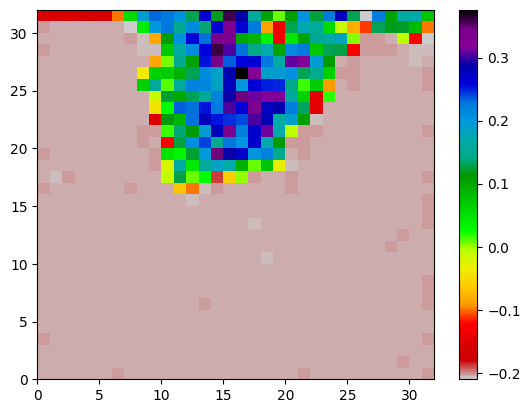

In [56]:
plt.pcolormesh(Y_pred[0, ..., 0], cmap=plt.cm.nipy_spectral_r)
plt.colorbar()

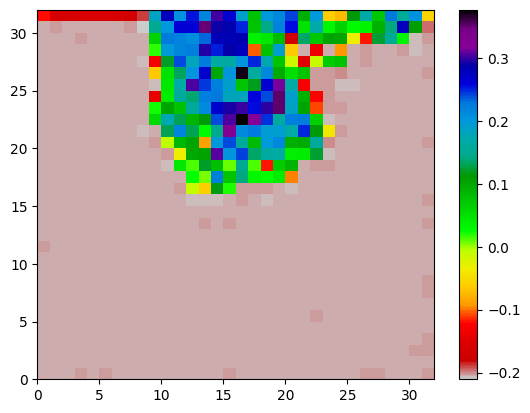

In [59]:
plt.pcolormesh(Y_pred[0, ..., 0], cmap=plt.cm.nipy_spectral_r)
plt.colorbar()

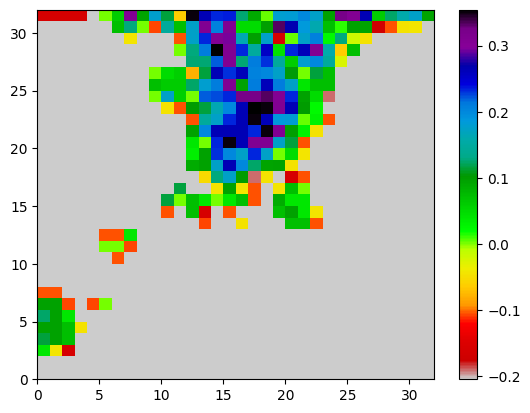

In [52]:
plt.pcolormesh(Y_valid[0, ..., 0], cmap=plt.cm.nipy_spectral_r)
plt.colorbar()

**Out-of-box reverse diffusion tests for debugging**

In [52]:
# x_in1 = images_valid
# x_in2 = X_valid

# x1 = x_in1[i, ...][None, ...]
# x2 = x_in2[i, ...][None, ...]

# t = 99
# tt = tf.cast(tf.fill(1, t), dtype=tf.int64)
# pred_noise = model.predict([x1, tt, x2], verbose=0)
# model_mean, _, model_log_variance =  gdf_util.p_mean_variance(pred_noise, x=x1, t=tt, clip_denoised=True)
# nonzero_mask = (1 - (np.array(tt)==0)).reshape((1, 1, 1, 1))
# x1 = np.array(model_mean) + nonzero_mask * np.exp(0.5 * np.array(model_log_variance)) * np.random.normal(size=x1.shape)

In [11]:
# x_in1 = images_valid
# x_in2 = X_valid

# x1 = x_in1[i, ...][None, ...]
# x2 = x_in2[i, ...][None, ...]

# for t in reversed(range(0, total_timesteps)):
#     tt = tf.cast(tf.fill(1, t), dtype=tf.int64)
#     pred_noise = model.predict([x1, tt, x2], verbose=0)
#     model_mean, _, model_log_variance =  gdf_util.p_mean_variance(pred_noise, x=x1, t=tt, clip_denoised=True)
#     nonzero_mask = (1 - (np.array(tt)==0)).reshape((1, 1, 1, 1))
#     x1 = np.array(model_mean) + nonzero_mask * np.exp(0.5 * np.array(model_log_variance)) * np.random.normal(size=x1.shape)

#     if np.sum(np.isnan(x1)) > 0:
#         print(t)
#         aergaegr